In [ ]:
!pip install pytesseract

In [ ]:
import cv2 # opencv
import numpy as np
import matplotlib.pyplot as plt #시각화
import pytesseract # 글자인식
plt.style.use('dark_background')

In [ ]:
file_url="https://postfiles.pstatic.net/MjAyMTA3MjNfMjg3/MDAxNjI3MDM5NDk2MDE4.KgB7ga0dj7QjAXsKIS_5bsgieJzwS2EPgy_YXpUIe6Ag.K-N12osGxa53oTA6mMjTG3ideZsey29l6Vq7lpxGAiMg.JPEG.mltmkr/%EC%82%AC%EC%A7%84_2_6%EC%9B%94_%EC%8B%AC%EC%95%84%EB%A6%84.jpg?type=w966"
# https://img3.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202302/28/MOTORGRAPH/20230228101122951ybnb.jpg

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


800 800 3


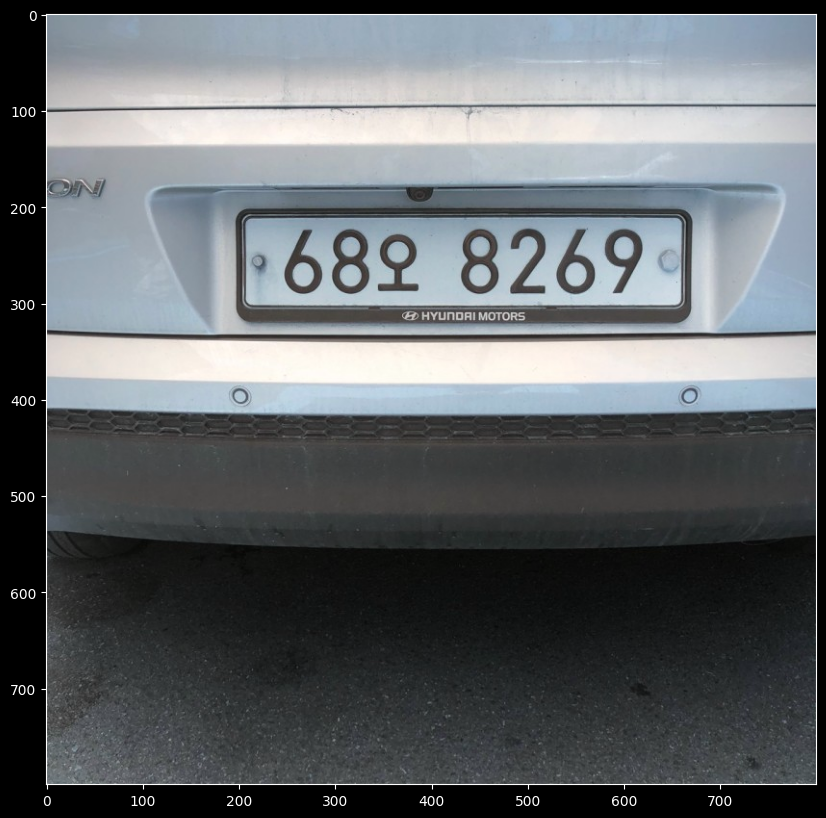

In [ ]:
file_path='/content/gdrive/My Drive/Image_Processing/car2.jpg'
img_ori = cv2.imread(file_path)

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)

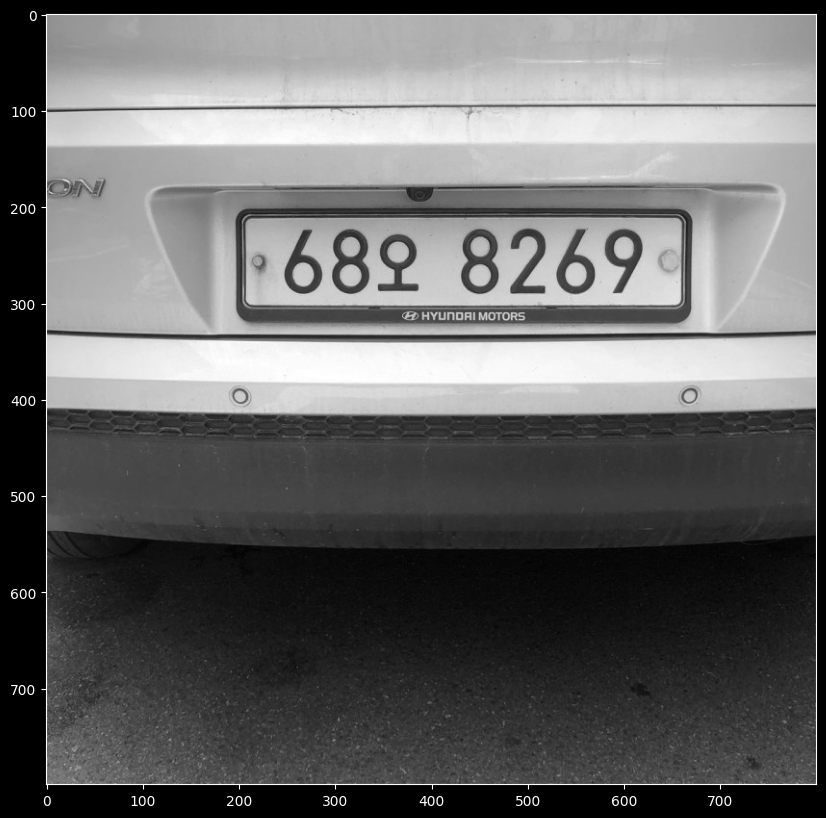

In [ ]:
# 회색으로 변환
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY) # hsv
# gray = hsv[:, :, 2]
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

In [ ]:
# 가우시안 블러=노이즈 삭제
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
# thresjolding
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

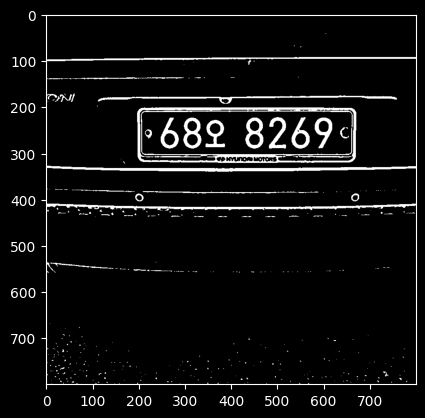

In [ ]:
plt.imshow(img_blur_thresh, cmap='gray')

In [ ]:
# 블러 처리 안함
# img_thresh = cv2.adaptiveThreshold(
#     gray,
#     maxValue=255.0,
#     adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#     thresholdType=cv2.THRESH_BINARY_INV,
#     blockSize=19,
#     C=9
# )
# plt.imshow(img_thresh, cmap='gray')

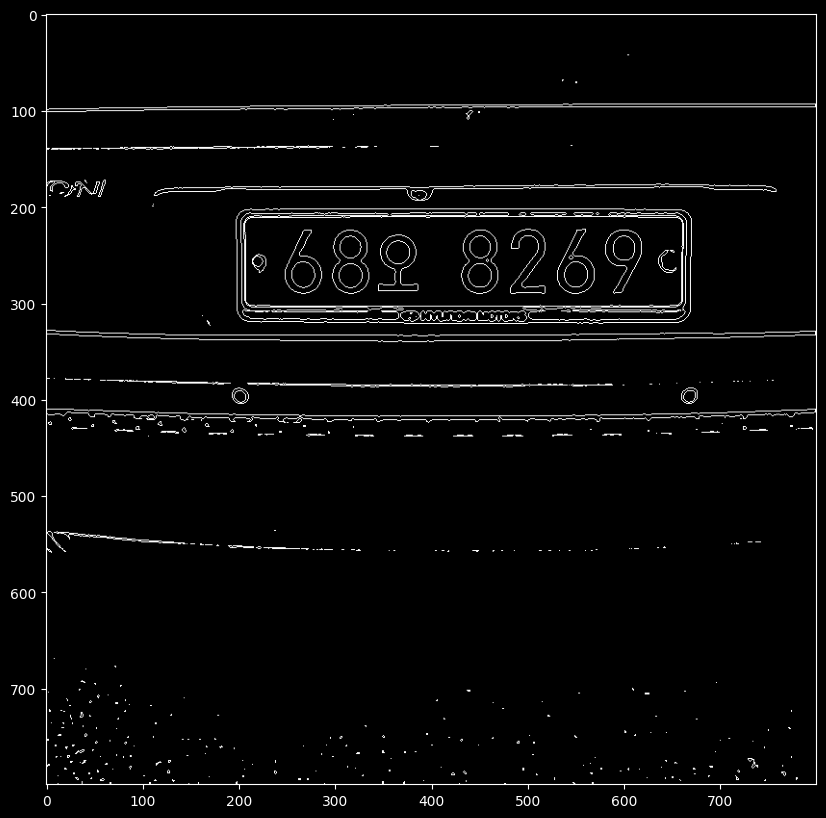

In [ ]:
# contours: 동일한 색과 강도를 가진 경계선을 연결한 선
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

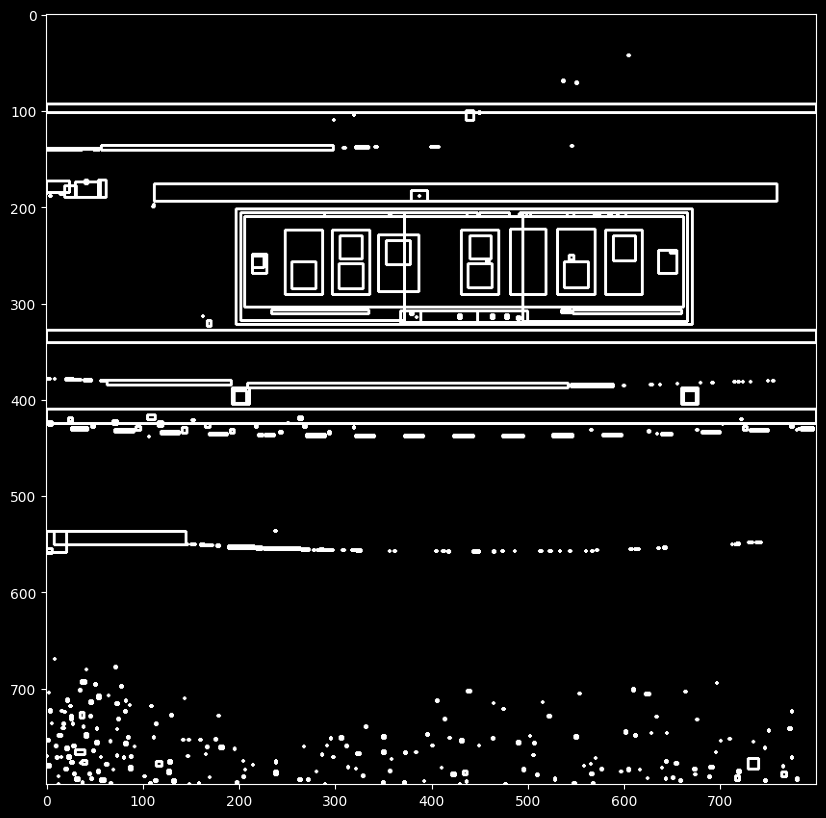

In [ ]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8) # 이미지와 동일한 크기 빈 공간

contours_dict = [] # 각 contours의 위치정보 저장

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

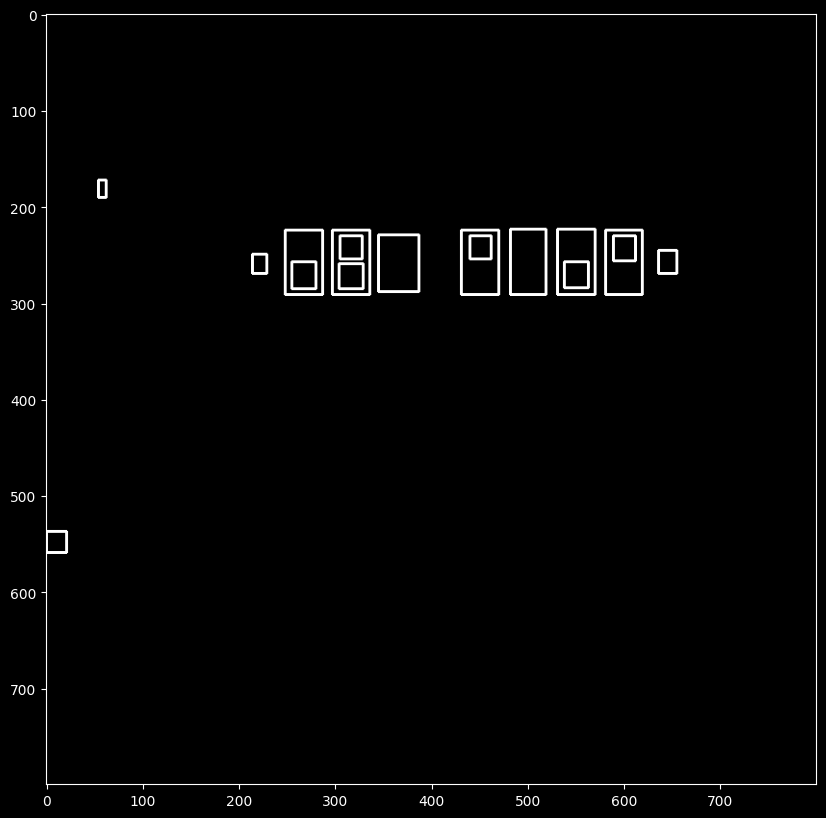

In [ ]:
# 일정 비율을 가지고 있는 번호판 숫자의 특성을 이용해 추려낸다.

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 최소비율, 최대비율

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h'] # 너비와 높이로 비율을 구한다.

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

### 기준강화
- 번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다.
- 번호판 Contours 사이의 간격은 일정하다.
- 최소 3개 이상 Contours가 인접해 있어야한다. (대한민국 기준)

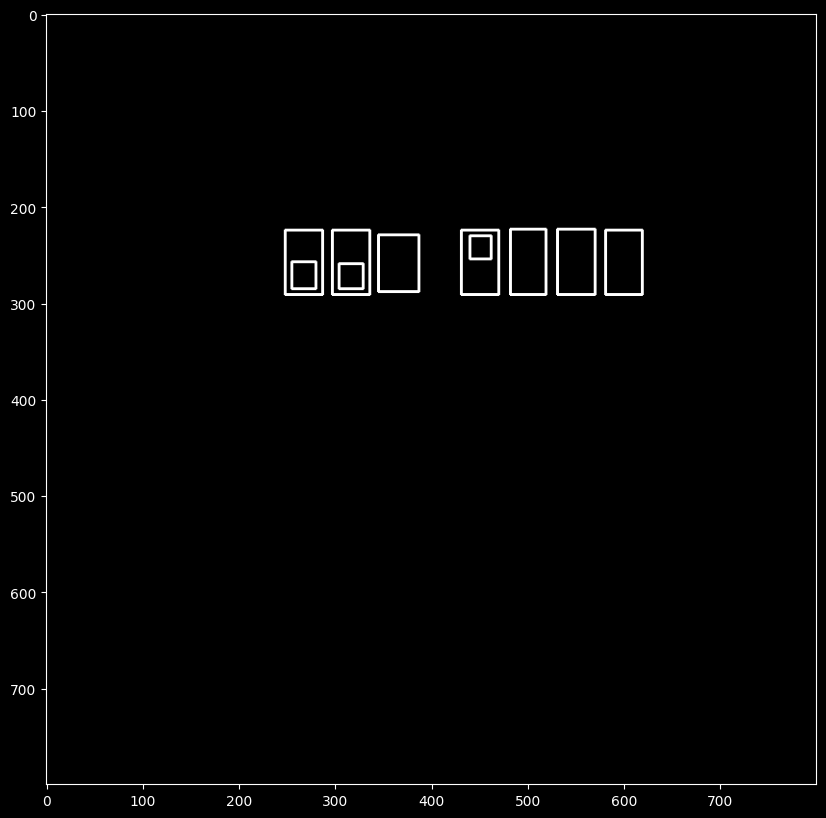

In [ ]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)# 조건에 맞지 않은 사각형의 정보를 인덱스로 가지고 온다.

        recursive_contour_list = find_chars(unmatched_contour)# 재귀. 또 찾아온다.

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx # 조건에 맞는 데이터 인덱스만 가지고 온다.

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list)) # 조건에 맞는 데이터만 가지고 온다.

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result: # 맞는 데이터만 저장됨.
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [ ]:
# 회전된 번호판 인식 방법
# Affine Transform 적용


In [ ]:
# #번호판 contours가 없었을 때를 위해 선별되지 못한 contours에 후보군을 추린다.
# longest_idx, longest_text = -1, 0
# plate_chars = []

# for i, plate_img in enumerate(plate_imgs):
#     plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
#     _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#     # find contours again (same as above)
#     contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

#     plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
#     plate_max_x, plate_max_y = 0, 0

#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)

#         area = w * h
#         ratio = w / h

#         if area > MIN_AREA \
#         and w > MIN_WIDTH and h > MIN_HEIGHT \
#         and MIN_RATIO < ratio < MAX_RATIO:
#             if x < plate_min_x:
#                 plate_min_x = x
#             if y < plate_min_y:
#                 plate_min_y = y
#             if x + w > plate_max_x:
#                 plate_max_x = x + w
#             if y + h > plate_max_y:
#                 plate_max_y = y + h

#     img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

In [ ]:
    # img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    # _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    # pytesseract.pytesseract.tesseract_cmd = "C:\Users\skadl\Downloads\tesseract-ocr-w64-setup-v5.3.0.20221214.exe"
    # chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')

    # result_chars = ''
    # has_digit = False
    # for c in chars:
    #     if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
    #         if c.isdigit():
    #             has_digit = True
    #         result_chars += c

    # print(result_chars)
    # plate_chars.append(result_chars)

    # if has_digit and len(result_chars) > longest_text:
    #     longest_idx = i

    # plt.subplot(len(plate_imgs), 1, i+1)
    # plt.imshow(img_result, cmap='gray')

In [ ]:
# info = plate_infos[longest_idx]
# chars = plate_chars[longest_idx]

# print(chars)

# img_out = img_ori.copy()

# cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

# cv2.imwrite(chars + '.jpg', img_out)

# plt.figure(figsize=(12, 10))
# plt.imshow(img_out)

In [ ]:
matched=matched_result[1] # 0: 작은거, 1: 큰거
len(matched)
# [array([{'contour': array([[[312, 260]],

#                [[313, 259]],

7

In [ ]:
def make_json(file_url,height,width,i, file_name,file_size):
  import datetime

  dt=datetime.datetime.today()

  date=dt.strftime("%Y-%m-%d")

  json={
    "original_img":
    {
      "file_path":file_url,
      "date":date,
      "C_name":"남인경",
      "original_size":[height, width]
    },
    "label_info":
    {
      "U_ID":"AA_000000"+str(i),
      "label_path":file_name,
      "label_num":"",
      "label_size":list(file_size)
    }
  }
  return json

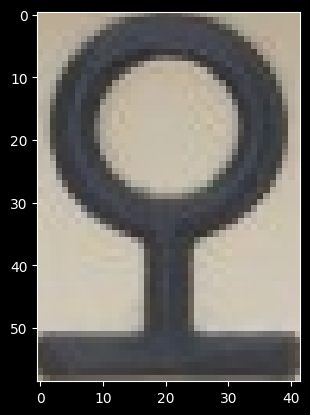

In [ ]:
# 분할된 이미지로 자르기
from PIL import Image
import json
i=0
for m in matched:
  img=Image.open('/content/gdrive/My Drive/Image_Processing/car2.jpg')

  cropped=img.crop((m['x'],m['y'],m['x']+m['w'], m['y']+m['h']))

  plt.imshow(cropped)
  file_size=cropped.size
  file_name=f'/content/gdrive/My Drive/Image_Processing/car/car2_{i}.jpg'
  json_string = json.dumps(make_json(file_url,height,width,i, file_name,file_size))

  cropped.save(file_name)
  with open(f'/content/gdrive/My Drive/Image_Processing/car/car2_{i}.json','w',encoding='utf-8') as make_file:
    make_file.write(json_string)
  i+=1

In [ ]:
# 파일 저장 완료
